In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

from scipy.stats import norm, skew, kurtosis, shapiro

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


Matplotlib is building the font cache; this may take a moment.


In [2]:
file_path = "data/EMECS_Raw_Data.xlsx"
countries = ['China', 'Germany', 'India', 'Russia', 'United States']
features = ['population', 'gdp', 'coal_co2', 'flaring_co2','gas_co2', 'methane', 'oil_co2', 'electricity_generation_twh']
target = 'co2'

In [3]:
raw_df = pd.read_excel(file_path, sheet_name="sheet1")
df = raw_df
df['year'] = pd.to_datetime(df['year'], format='%Y')
df.index = df['year']
df_test = df.drop(columns=['year', 'iso_code', 'code_year', ])

# Explortary Data Analysis

## Normal Distribution Check

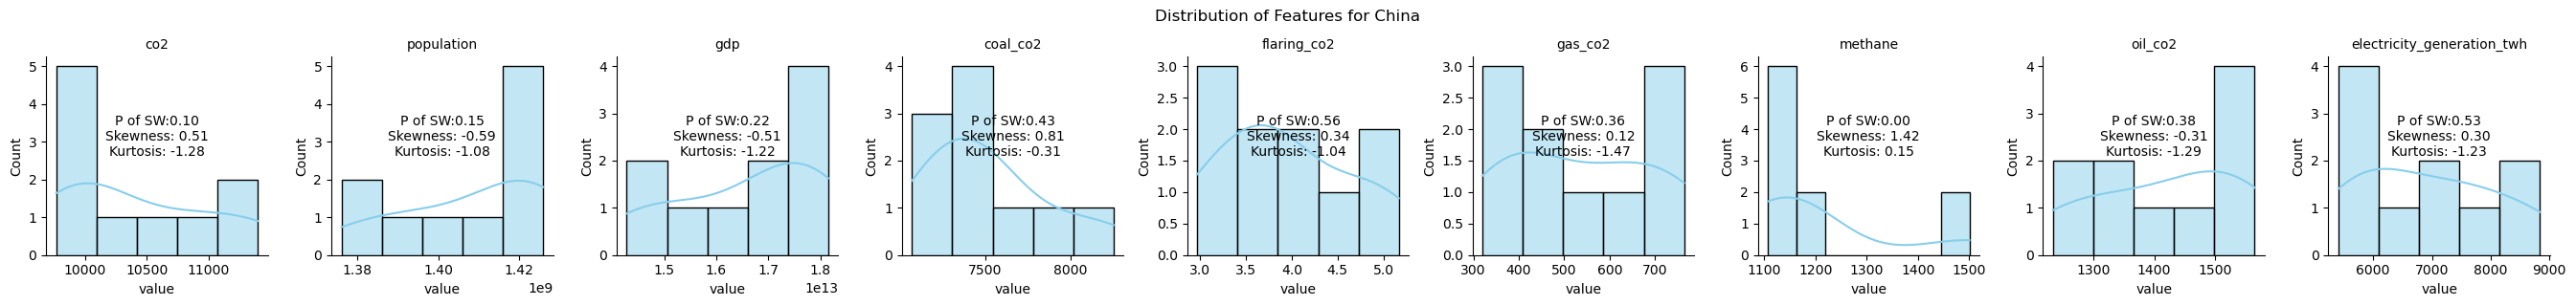

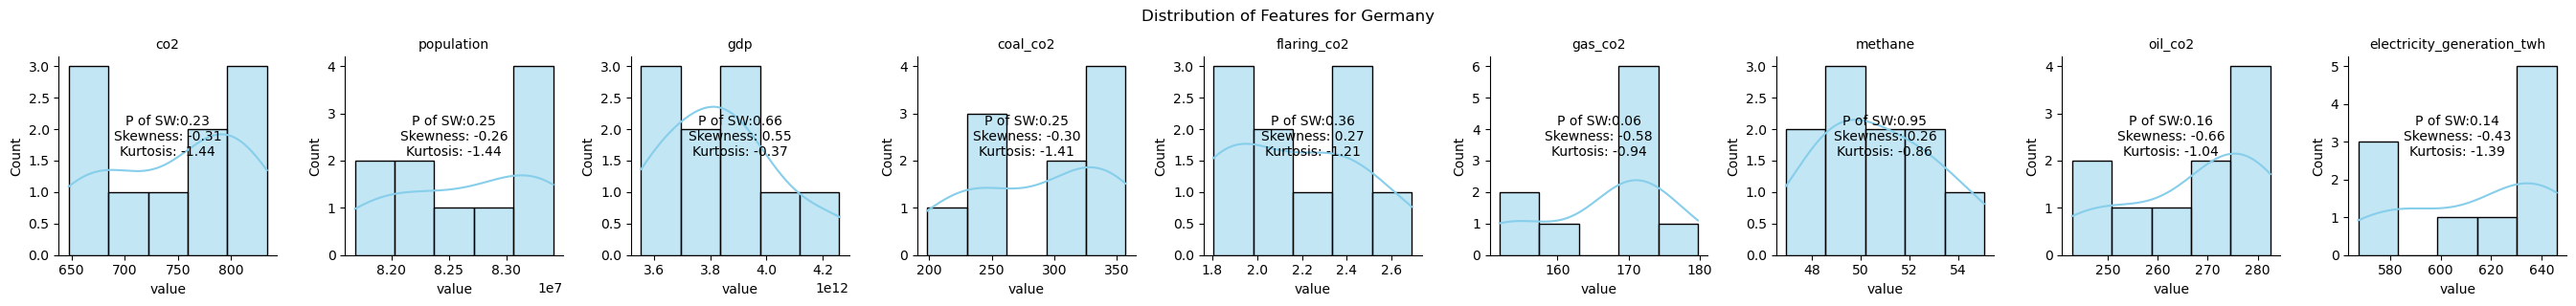

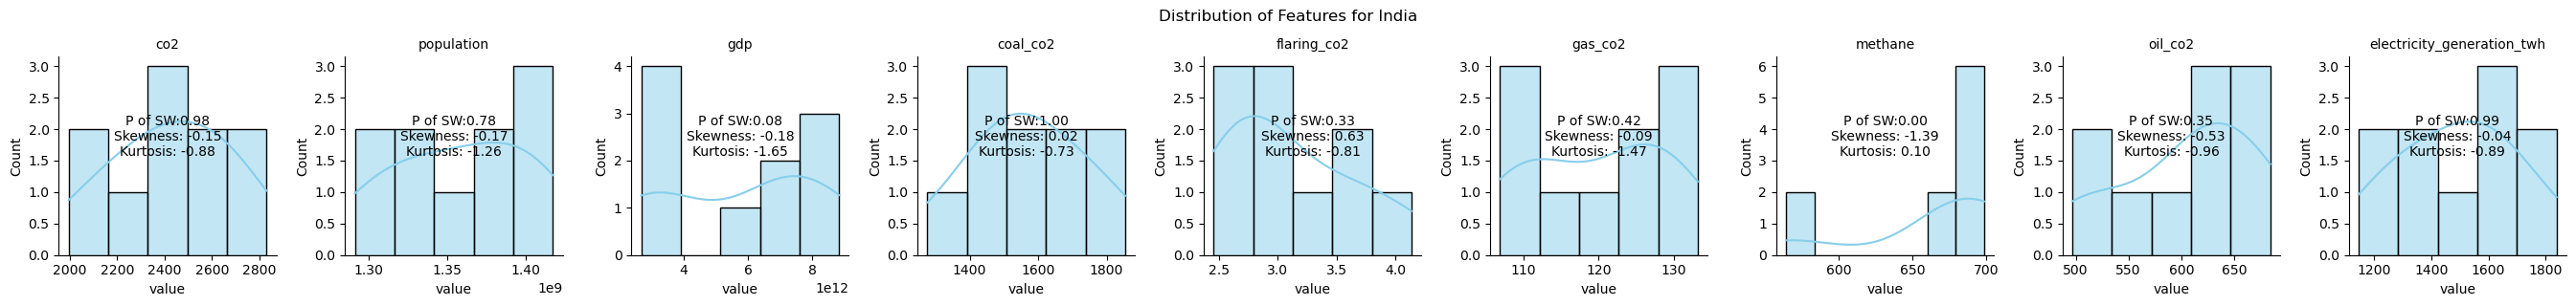

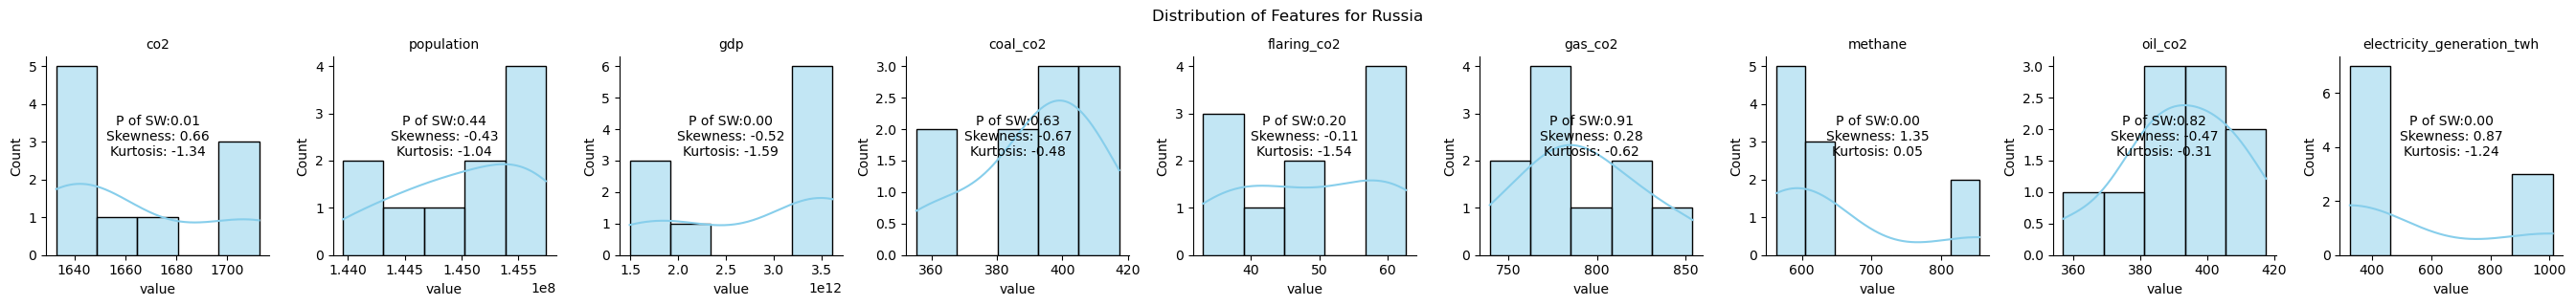

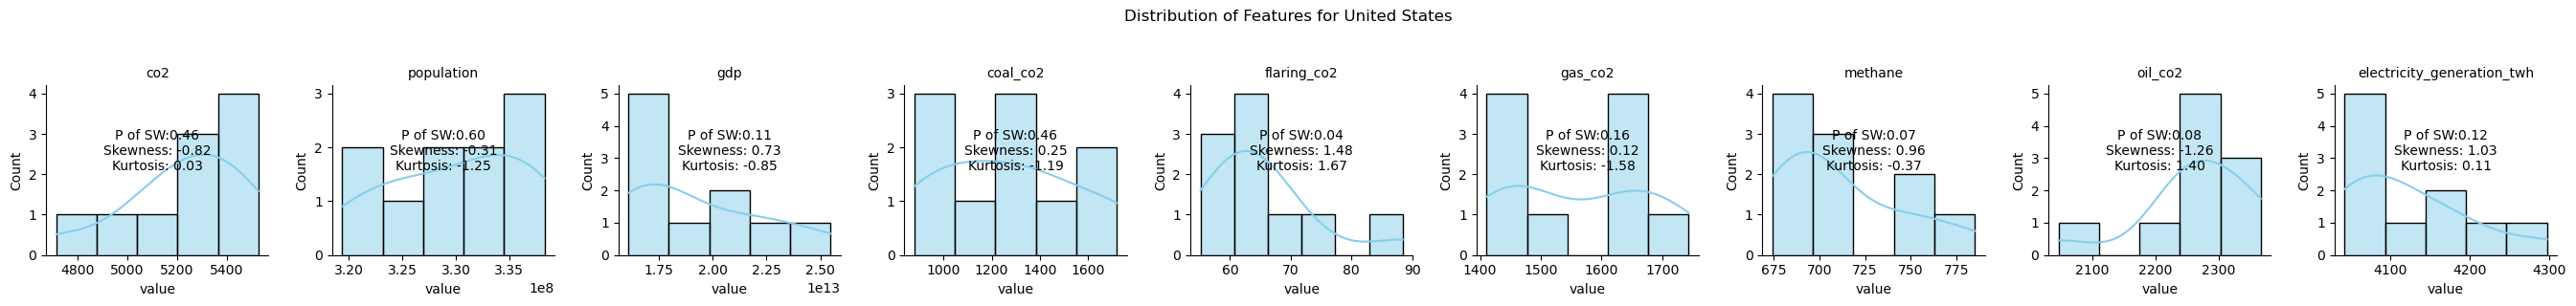

In [4]:

# Function to annotate plots with skewness and kurtosis values
def annotate_skew_kurt_swp(data, **kwargs):
    skewness = skew(data)
    kurt = kurtosis(data)
    stat, swp = shapiro(data)
    plt.text(0.5, 0.5, f'P of SW:{swp:.2f}\nSkewness: {skewness:.2f}\nKurtosis: {kurt:.2f}', fontsize=10, ha='center', transform=plt.gca().transAxes)

# Plot features in parallel for each country
for country in countries:
    country_data = df_test[df_test['country'] == country].drop(columns=['country'])
    country_data = country_data[[target] + features]
    g = sns.FacetGrid(country_data.melt(), col='variable', col_wrap=9, sharex=False, sharey=False)
    g.map_dataframe(sns.histplot, x='value', kde=True, color='skyblue', edgecolor='black')
    g.map(annotate_skew_kurt_swp, 'value')
    g.set_titles('{col_name}')
    g.fig.suptitle(f'Distribution of Features for {country}', y=1.05)
plt.tight_layout()
plt.show()

In [5]:
# Melt the dataframe
df_melted = df_test.melt(id_vars=['country'], var_name='feature', value_name='value')
df_melted['transfer_type']='oringinal'
df_melted

# Function to calculate log and square root values for each feature
def transform_value(value, transfer_type):
    if transfer_type == 'log':
        return np.log(value)
    elif transfer_type == 'sqrt':
        return np.sqrt(value)
    else:
        return value
    
# List to store transformed data
transformed_data = []

# Iterate over each row in the DataFrame
for index, row in df_melted.iterrows():
    for transfer_type in ['log', 'sqrt']:
        transformed_value = transform_value(row['value'], transfer_type)
        transformed_data.append({
            'country': row['country'],
            'feature': row['feature'],
            'value': transformed_value,
            'transfer_type': transfer_type
        })

# Create a new DataFrame from the transformed data
transformed_df = pd.DataFrame(transformed_data)

# Concatenate the original DataFrame with the transformed DataFrame
final_df = pd.concat([df_melted, transformed_df])

final_df

,country,feature,value,transfer_type
0,Canada,population,3.506370e+07,oringinal
1,Canada,population,3.540462e+07,oringinal
2,Canada,population,3.573212e+07,oringinal
3,Canada,population,3.611353e+07,oringinal
4,Canada,population,3.655434e+07,oringinal
...,...,...,...,...
1795,United States,electricity_generation_twh,6.358600e+01,sqrt
1796,United States,electricity_generation_twh,8.331736e+00,log
1797,United States,electricity_generation_twh,6.444858e+01,sqrt
1798,United States,electricity_generation_twh,8.365644e+00,log


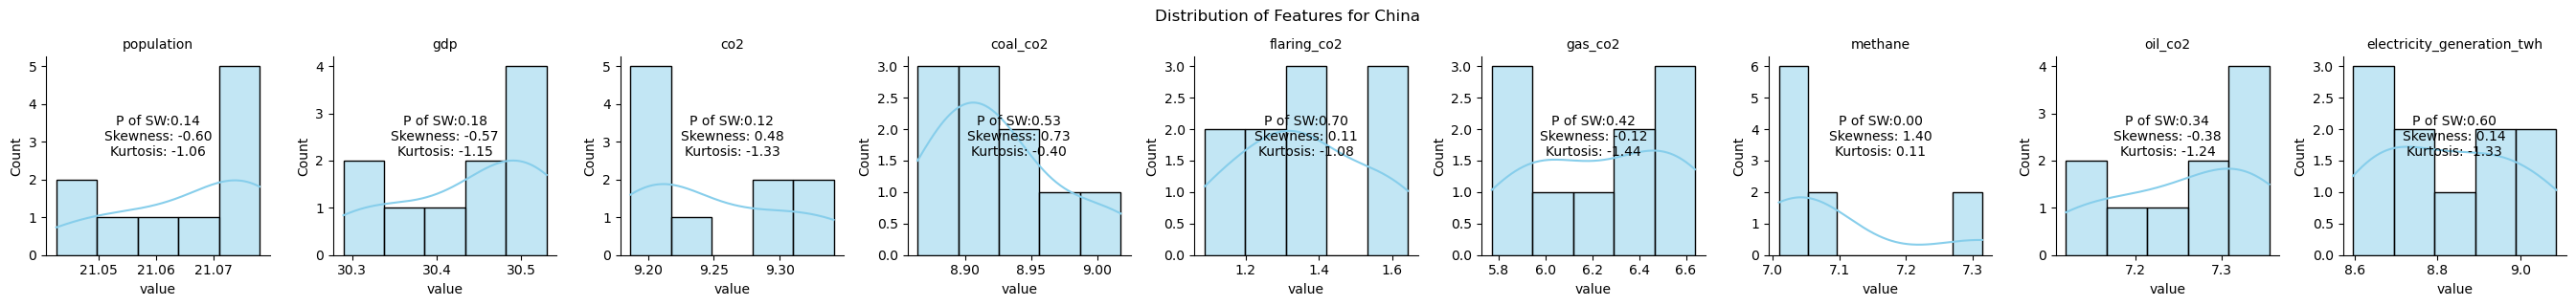

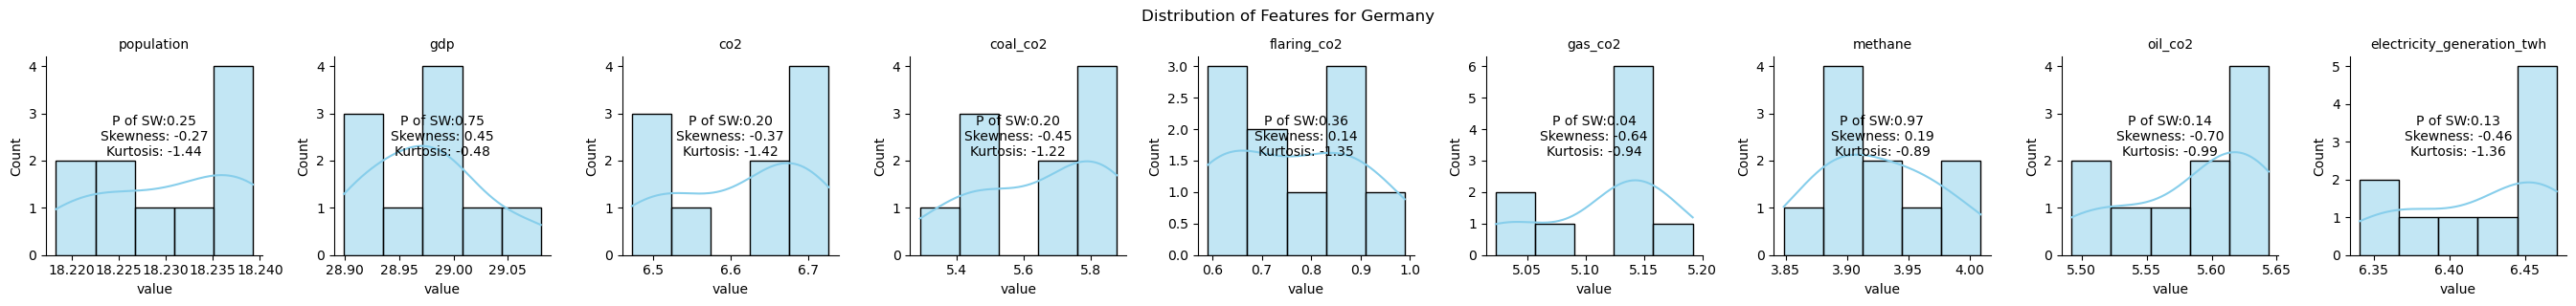

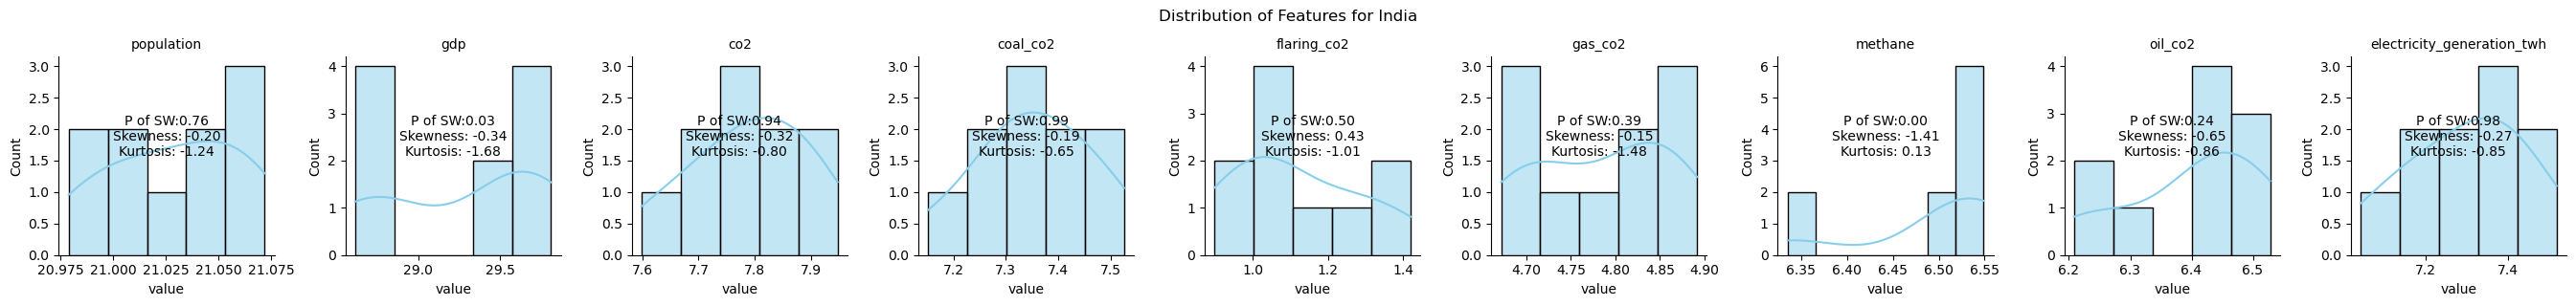

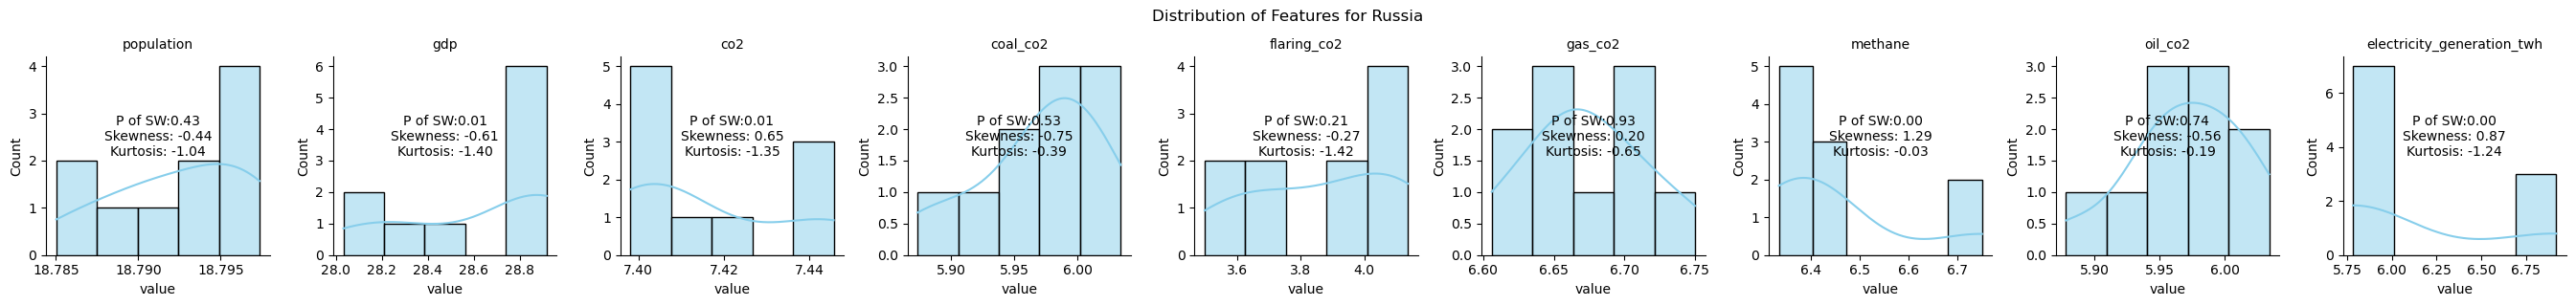

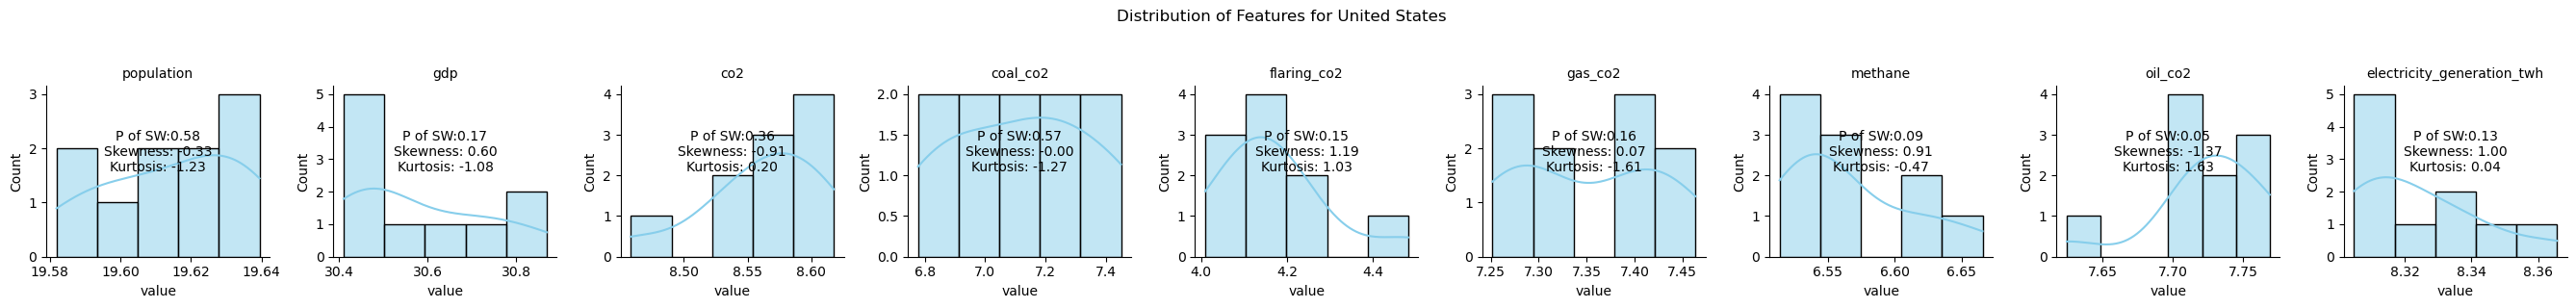

In [6]:
# Plot features in parallel for each country
for country in countries:
    country_data = final_df[final_df['country'] == country].drop(columns=['country'])
    country_data = country_data[country_data['transfer_type'] == 'log'].drop(columns=['transfer_type'])
    g = sns.FacetGrid(country_data, col='feature', col_wrap=len(country_data.feature.unique()), sharex=False, sharey=False)
    g.map_dataframe(sns.histplot, x='value', kde=True, color='skyblue', edgecolor='black')
    g.map(annotate_skew_kurt_swp, 'value')
    g.set_titles('{col_name}')
    g.fig.suptitle(f'Distribution of Features for {country}', y=1.05)
plt.tight_layout()
plt.show()

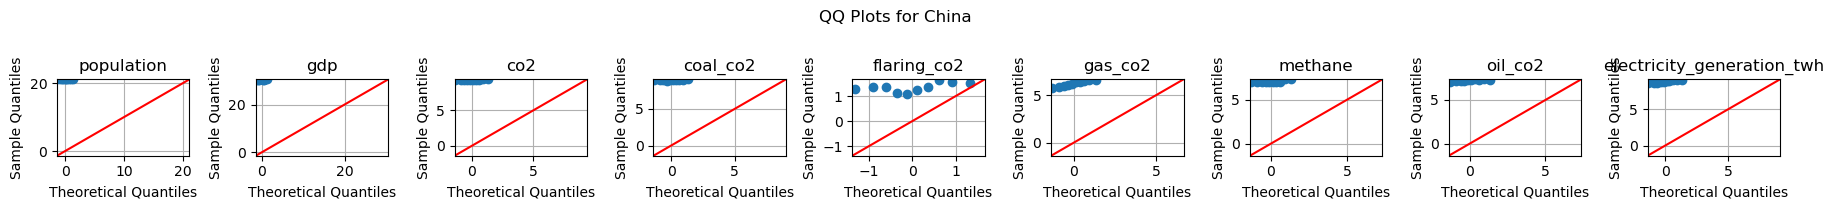

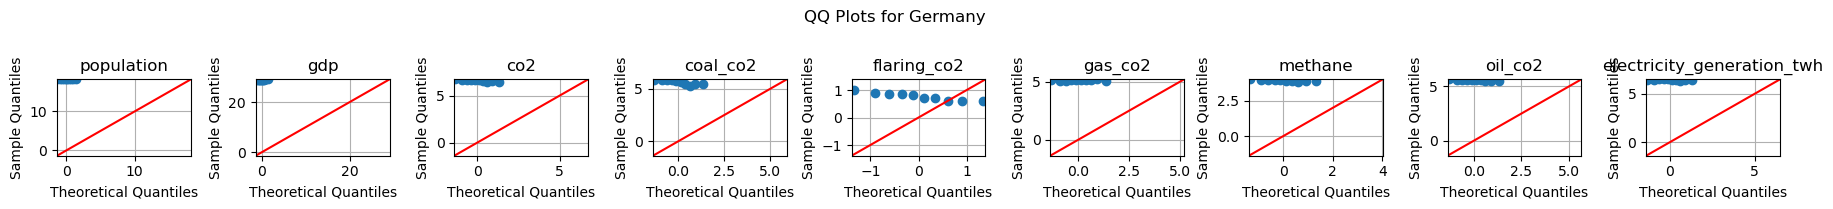

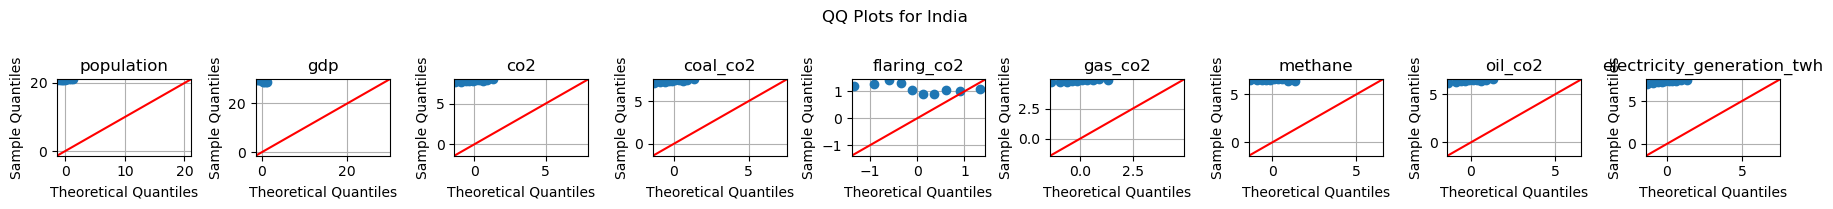

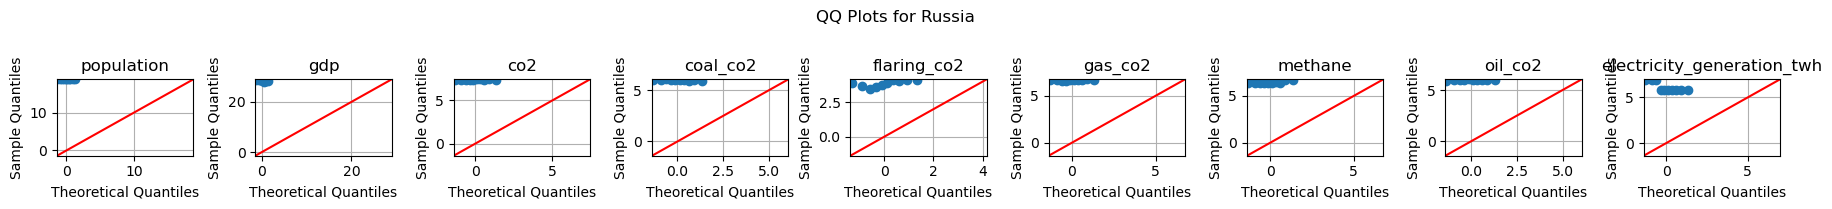

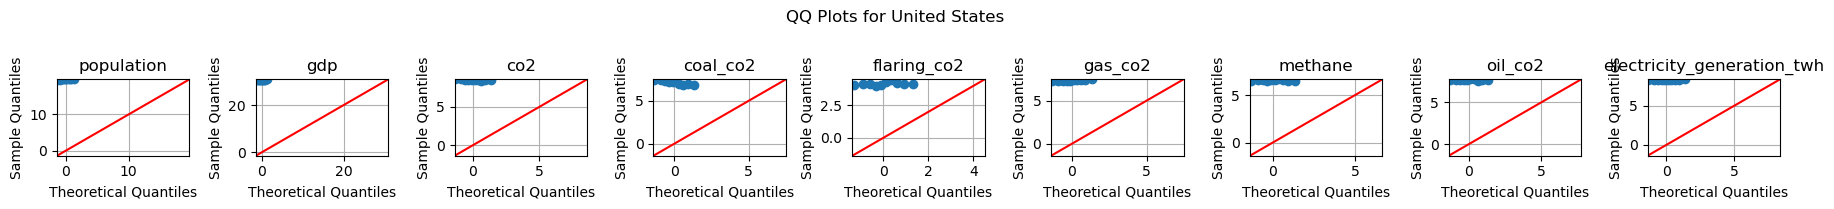

In [7]:

# Create QQ plots for all features in parallel for each country
for country in countries:
    # Select data for the current country
    data_country = final_df[final_df['country'] == country].drop(columns=['country'])
    data_country = data_country[data_country['transfer_type'] == 'log'].drop(columns=['transfer_type'])
    # Create QQ plot for each feature
    fig, axes = plt.subplots(nrows=1, ncols=len(data_country.feature.unique()), figsize=(18, 2))
    fig.suptitle(f'QQ Plots for {country}', y=1.02)
    
    for i, feature in enumerate(data_country.feature.unique()):
        # Create QQ plot for the current feature
        feature_data = data_country[data_country['feature'] == feature].drop(columns=['feature'])
        sm.qqplot(feature_data, line='45', ax=axes[i])
        axes[i].set_title(feature)
        axes[i].grid(True)

    plt.tight_layout()
    plt.show()

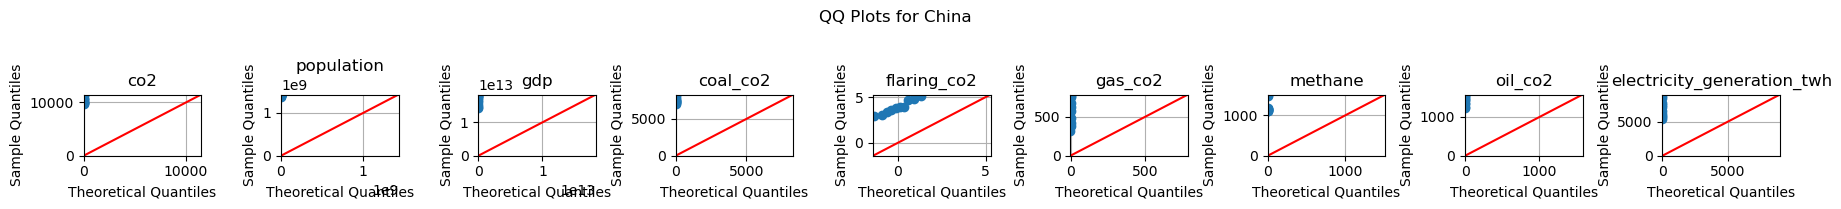

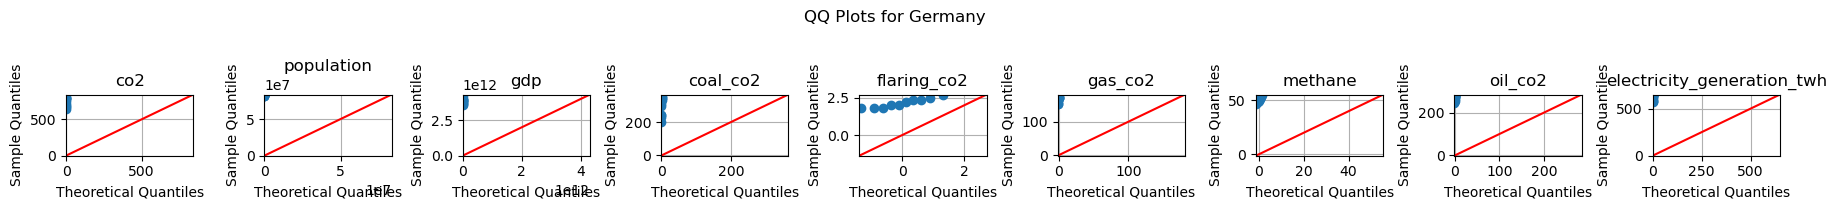

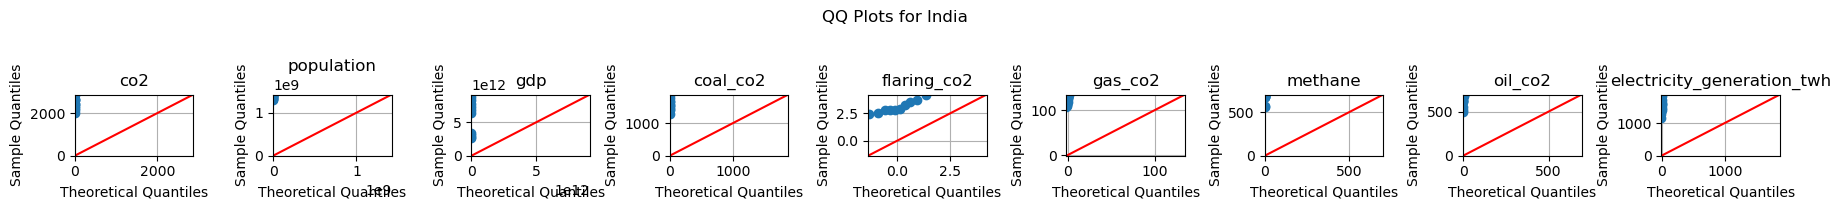

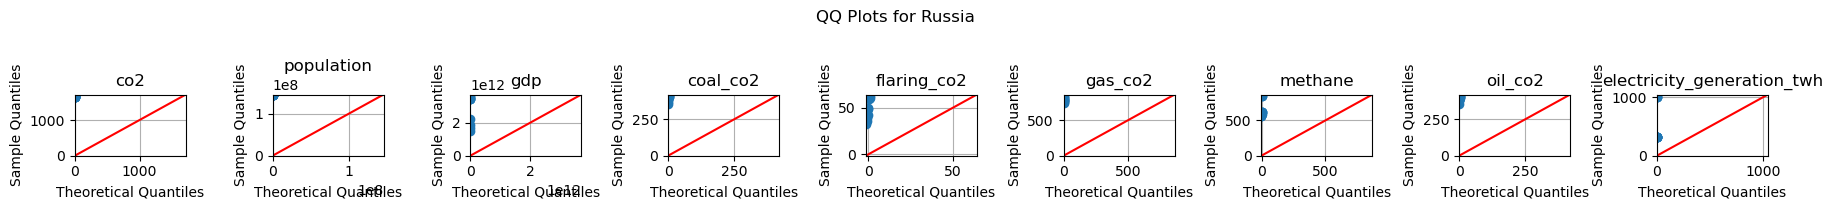

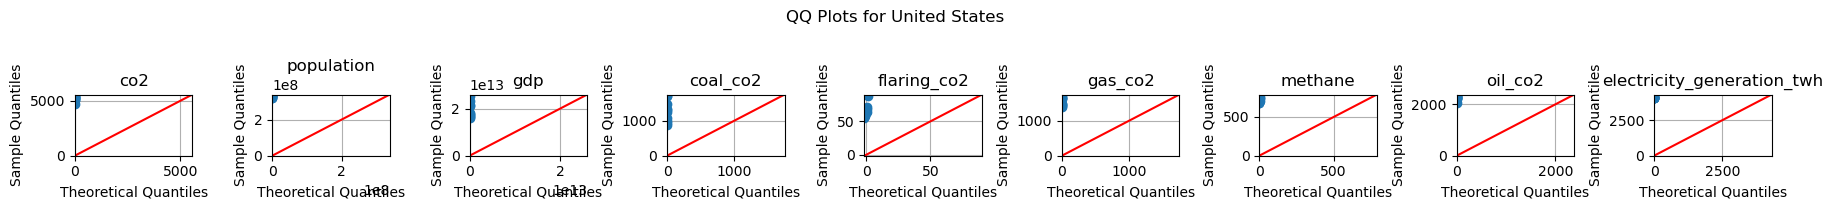

In [8]:

qq_coutry = df_test[df_test['country'].isin(countries)]
qq_coutry = qq_coutry[[target] + features+['country']]

# Create QQ plots for all features in parallel for each country
for country in countries:
    # Select data for the current country
    data_country = qq_coutry[qq_coutry['country'] == country].drop('country', axis=1)
    # Create QQ plot for each feature
    fig, axes = plt.subplots(nrows=1, ncols=len(data_country.columns), figsize=(18, 2))
    fig.suptitle(f'QQ Plots for {country}', y=1.02)
    
    for i, feature in enumerate(data_country.columns):
        # Create QQ plot for the current feature
        sm.qqplot(data_country[feature], line='45', ax=axes[i])
        axes[i].set_title(feature)
        axes[i].grid(True)

    plt.tight_layout()
    plt.show()

In [9]:
# Perform non-parametric tests for each feature
from scipy.stats import ranksums, kruskal

# Perform non-parametric tests for each feature
for feature in [target]+features:
    print(f"\n--- {feature} ---")
    # for country1 in countries:
    #     for country2 in countries:
    #         if country1 != country2:
    #             group1 = df_test[df_test['country'] == country1][feature]
    #             group2 = df_test[df_test['country'] == country2][feature]
    #             # Wilcoxon rank-sum test (Mann-Whitney U test) to compare two independent samples
    #             statistic, p_value = ranksums(group1, group2)
    #             print(f"Wilcoxon rank-sum test between {country1} and {country2}:")
    #             print("Statistic:", statistic)
    #             print("p-value:", p_value)

    # Kruskal-Wallis H test to compare more than two independent samples
    statistic, p_value = kruskal(*[df_test[df_test['country'] == country][feature] for country in countries])
    print("\nKruskal-Wallis H test across all countries:")
    print("Statistic:", statistic)
    print("p-value:", p_value)


--- co2 ---

Kruskal-Wallis H test across all countries:
Statistic: 47.05882352941174
p-value: 1.4824956979296822e-09

--- population ---

Kruskal-Wallis H test across all countries:
Statistic: 45.9256470588235
p-value: 2.55217495024362e-09

--- gdp ---

Kruskal-Wallis H test across all countries:
Statistic: 39.553882352941145
p-value: 5.352604912564161e-08

--- coal_co2 ---

Kruskal-Wallis H test across all countries:
Statistic: 45.4042352941176
p-value: 3.2762929538131514e-09

--- flaring_co2 ---

Kruskal-Wallis H test across all countries:
Statistic: 44.557691014743284
p-value: 4.913396035273481e-09

--- gas_co2 ---

Kruskal-Wallis H test across all countries:
Statistic: 46.69741176470586
p-value: 1.763038350566034e-09

--- methane ---

Kruskal-Wallis H test across all countries:
Statistic: 40.529882352941144
p-value: 3.3628853142793885e-08

--- oil_co2 ---

Kruskal-Wallis H test across all countries:
Statistic: 47.05882352941174
p-value: 1.4824956979296822e-09

--- electricity_gen

## Linear Relationship Check

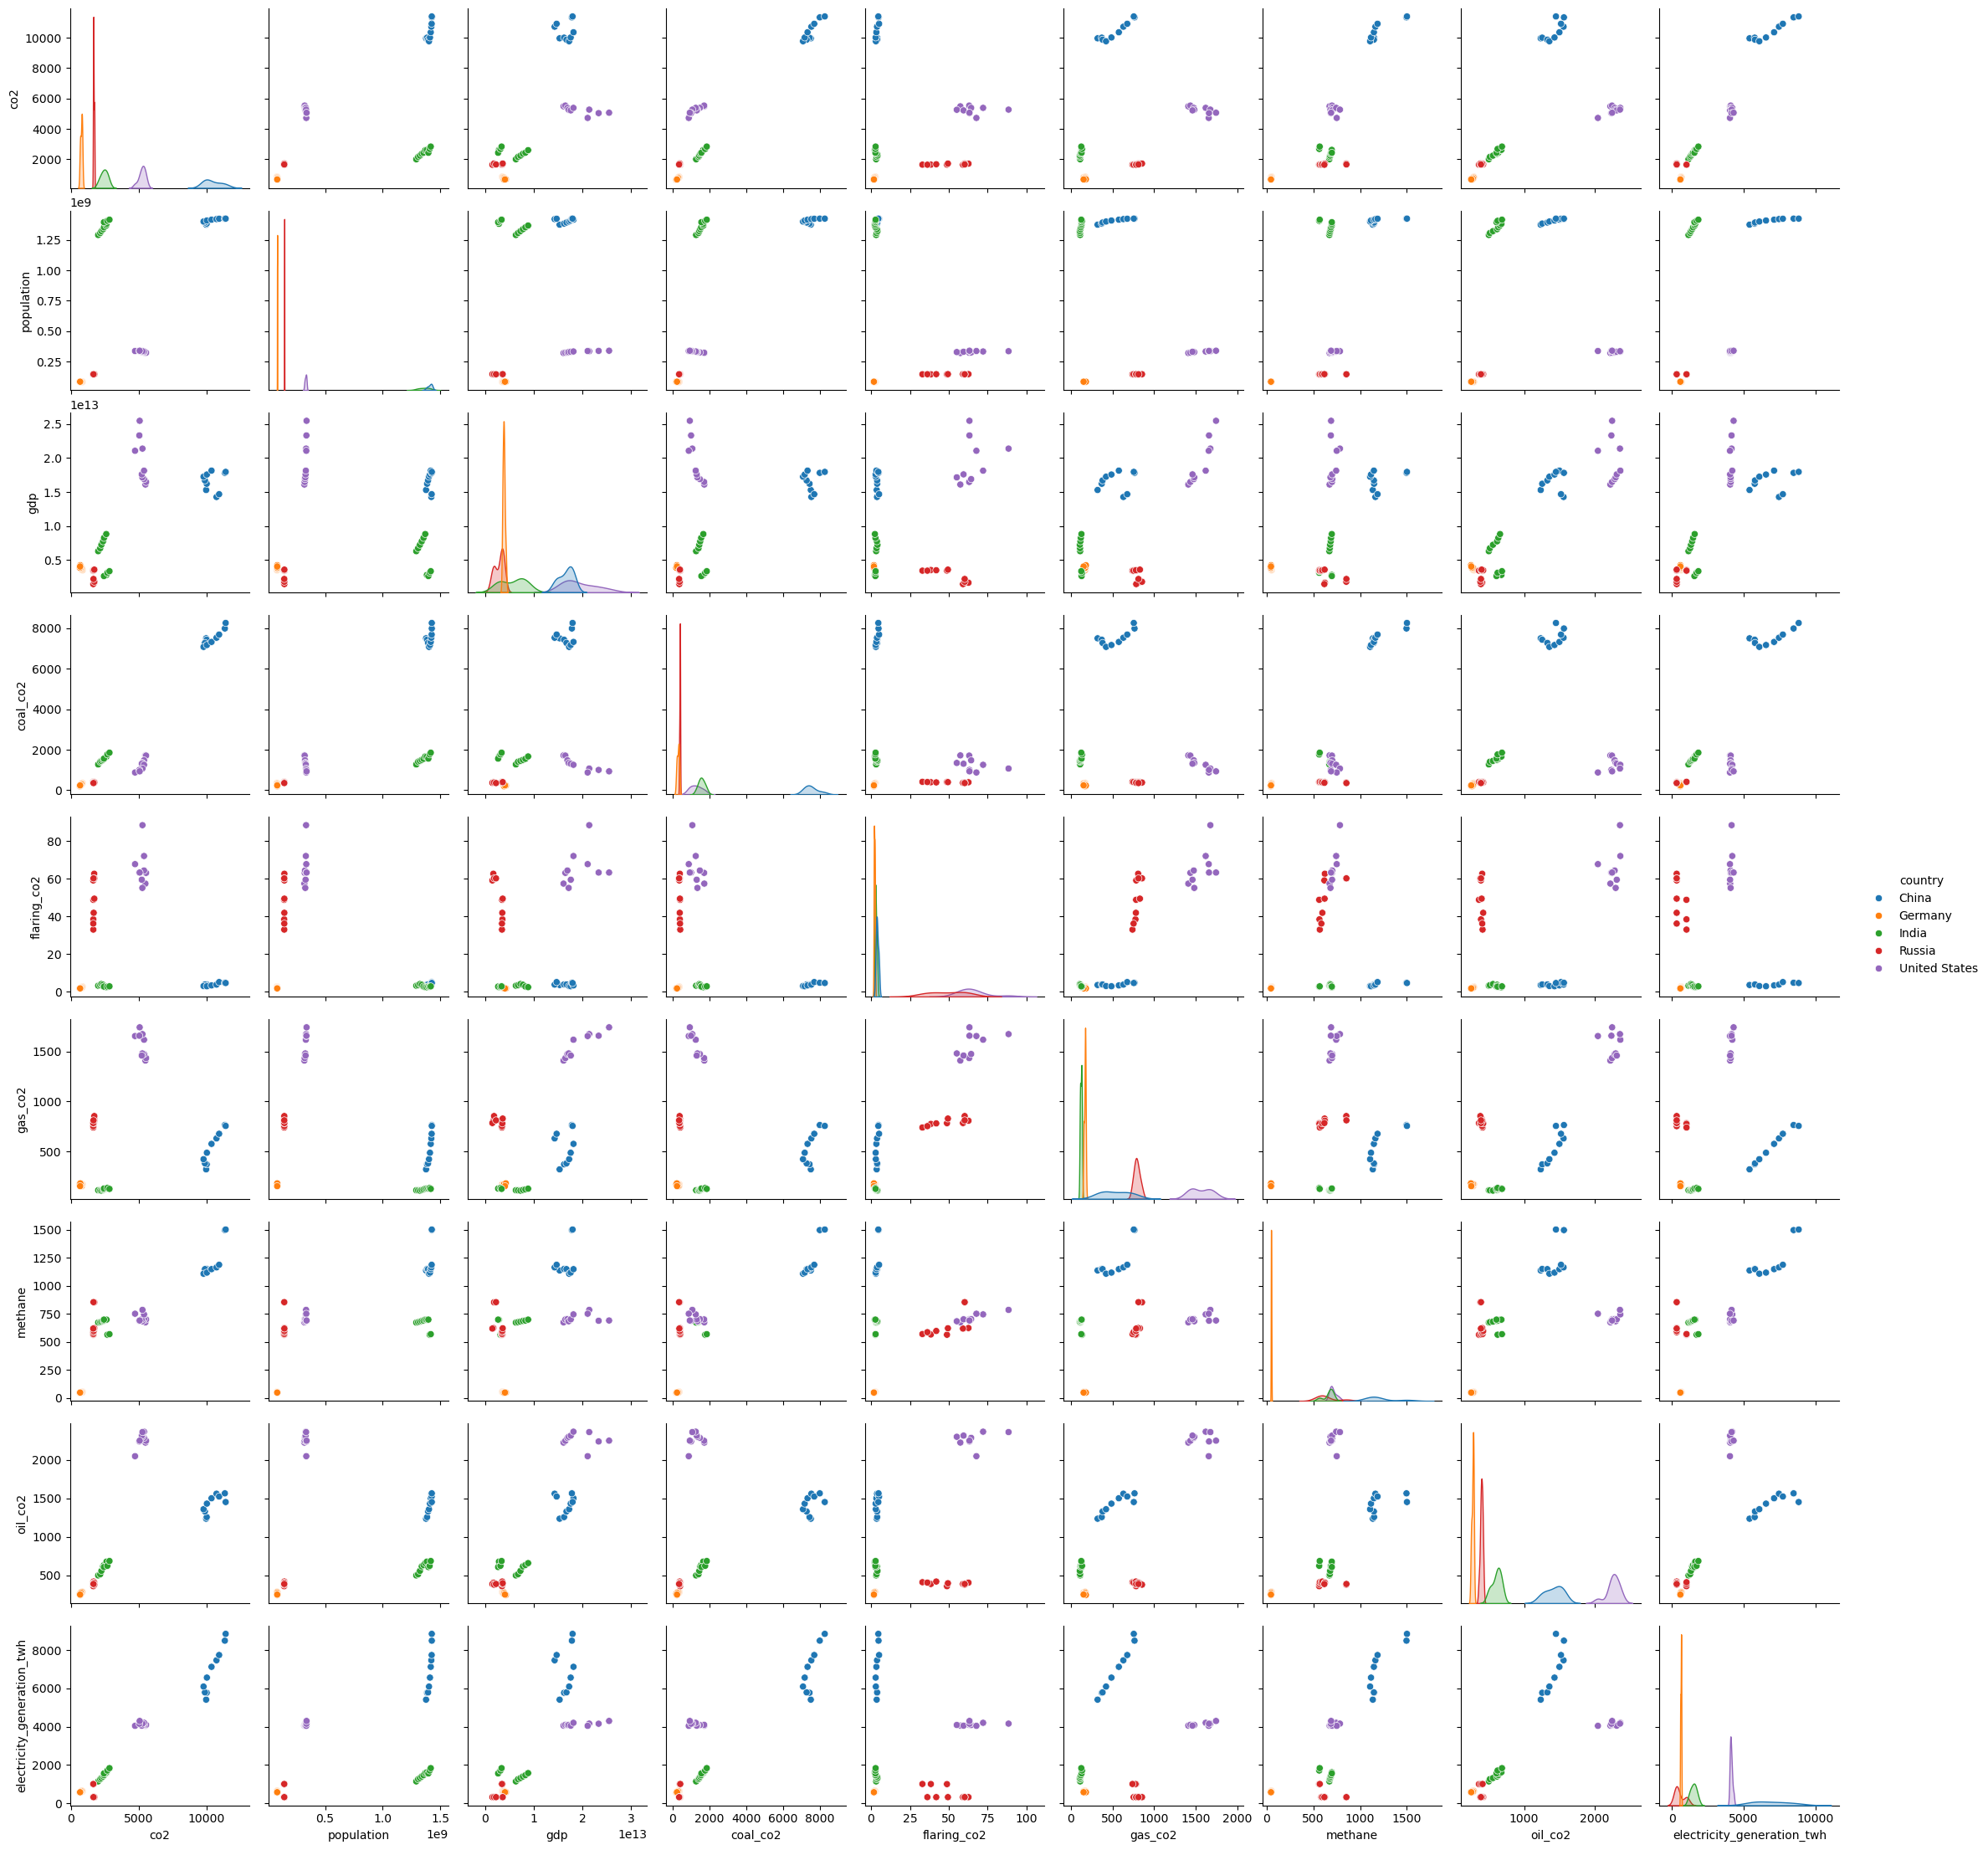

In [10]:
# Plotting
qq_coutry = df_test[df_test['country'].isin(countries)]
qq_coutry = qq_coutry[['country',target]+features]
sns.pairplot(qq_coutry, hue='country', diag_kind='kde')
plt.show()

## Correlation Check

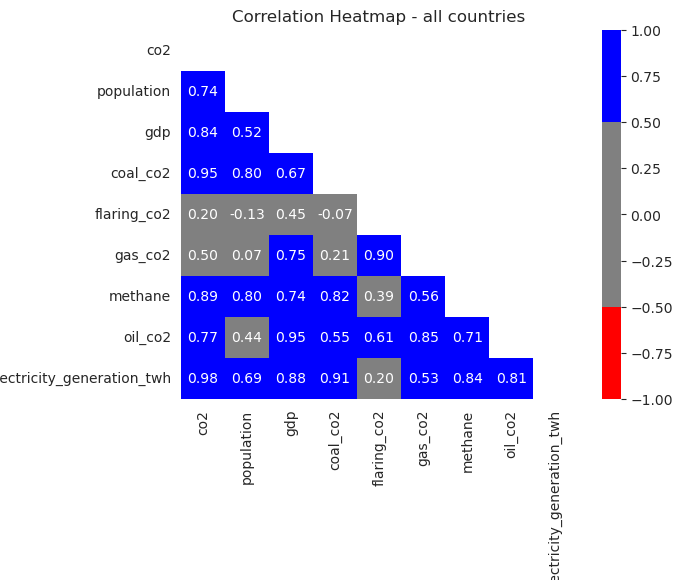

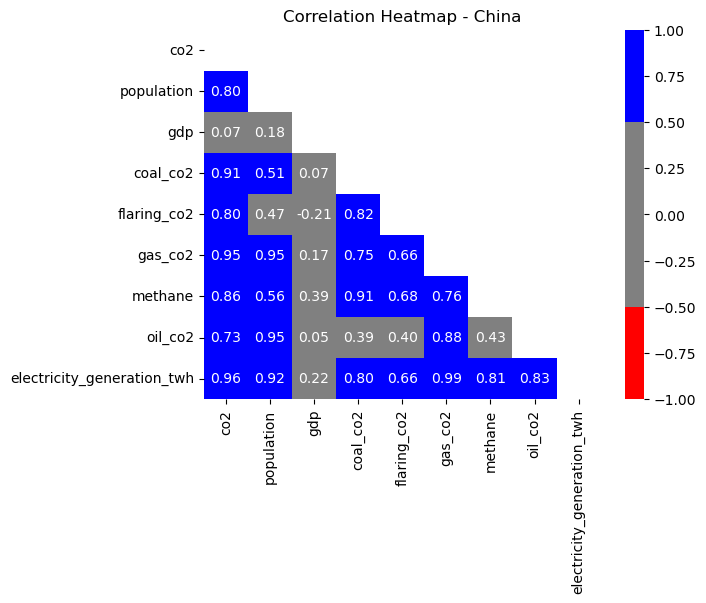

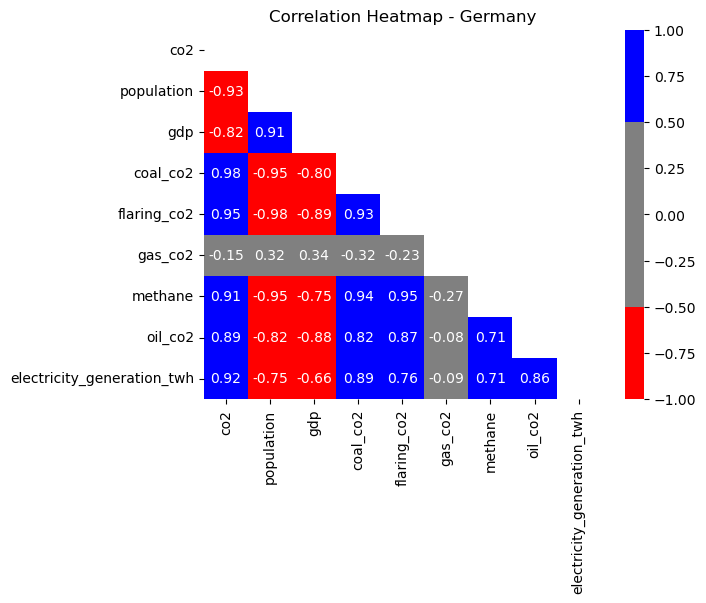

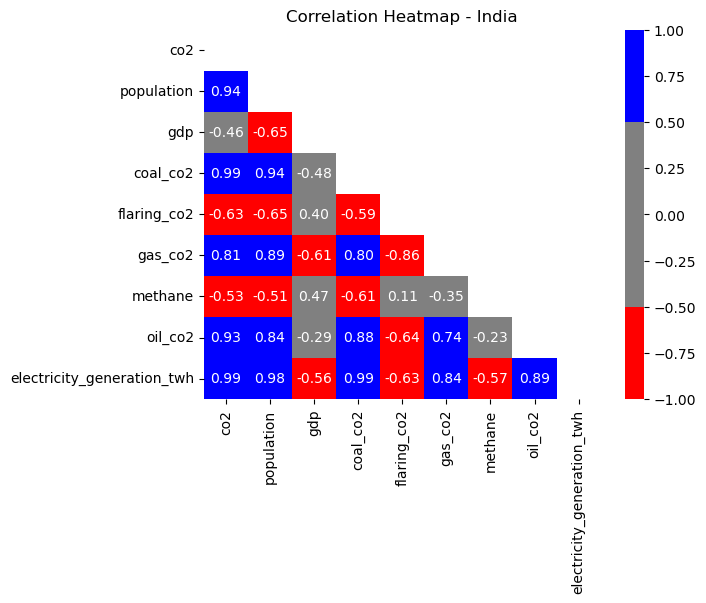

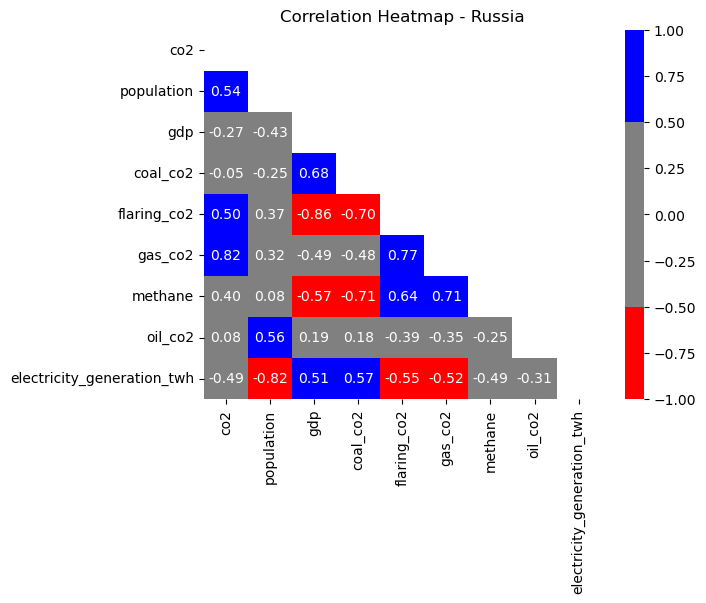

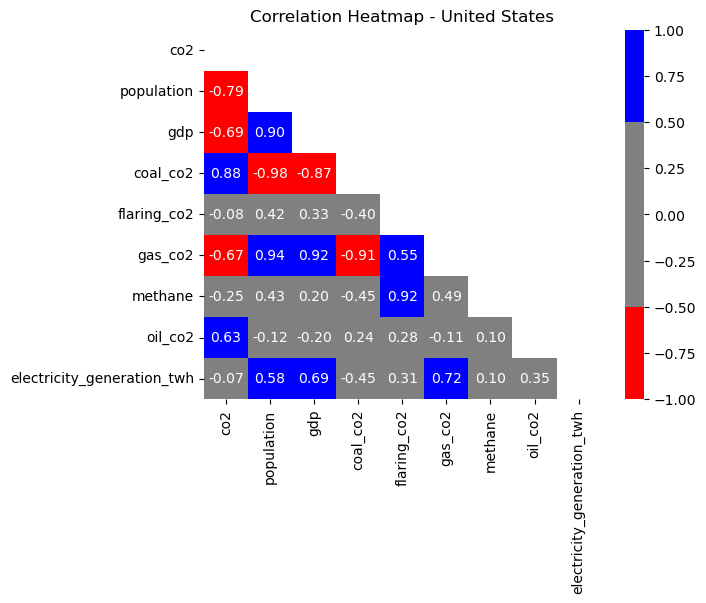

In [11]:

# Custom colormap
colors = ['red', 'gray','gray', 'blue']
cmap = ListedColormap(colors)

df_test = df.drop(columns=['year', 'iso_code', 'code_year', ])
df_co2_features = df_test.drop(columns=['country'])
df_co2_features = df_co2_features[[target]+features]
mask = np.zeros_like(df_co2_features.corr())
mask[np.triu_indices_from(mask)] = True
with sns.axes_style('white'):
    f, ax = plt.subplots()
    ax = sns.heatmap(df_co2_features.corr(), mask=mask, annot=True, cmap=cmap, fmt=".2f", vmin=-1, vmax=1)
plt.title(f'Correlation Heatmap - all countries')
plt.show()
for country in countries:
    df_country= df_test[df_test['country']==country]
    df_country = df_country.drop(columns=['country'])
    df_country = df_country[[target]+features]
    sns.heatmap(df_country.corr(), mask=mask, annot=True, cmap=cmap, fmt=".2f", vmin=-1, vmax=1)
    plt.title(f'Correlation Heatmap - {country}')
    plt.show()
    

## Outlier Check

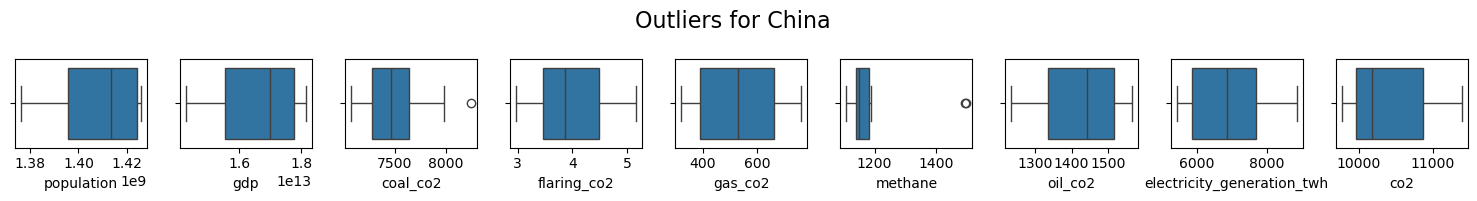

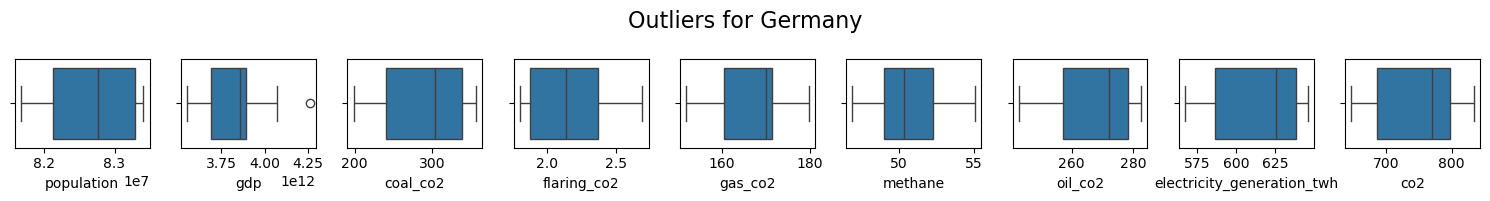

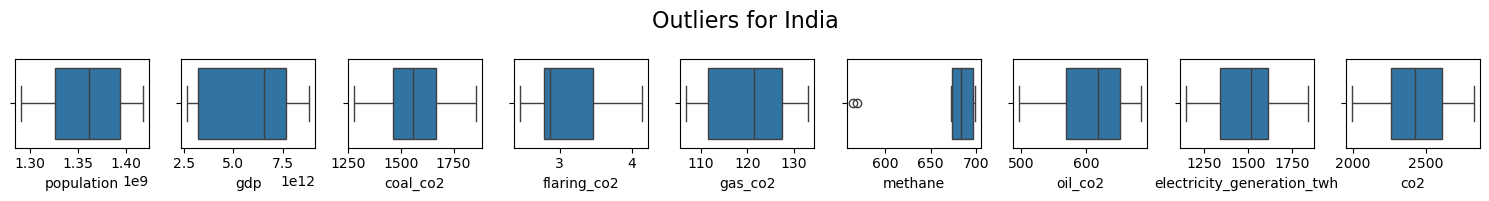

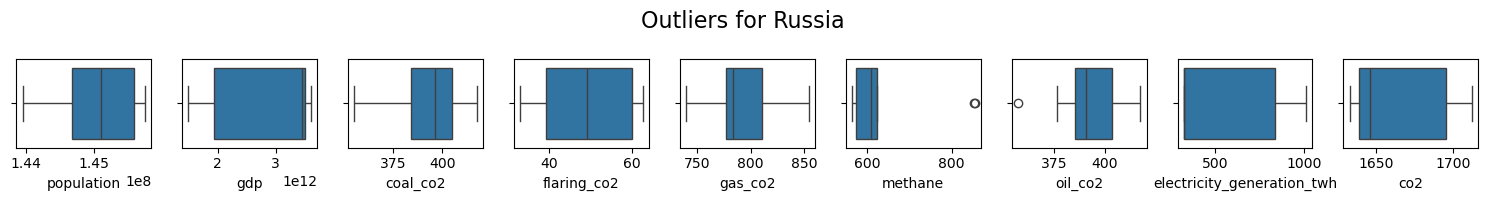

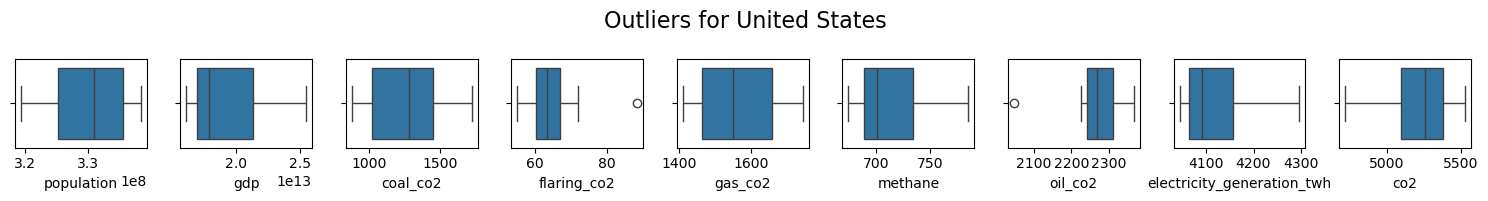

In [12]:

qq_coutry = df_test[df_test['country'].isin(countries)]

for country in countries:
    plt.figure(figsize=(15, 2))
    plt.suptitle(f'Outliers for {country}', fontsize=16)
    coutry_outliers = qq_coutry[qq_coutry['country']==country].drop(columns=['country'])
    # Plotting outliers for each feature of each country
    for i, feature in enumerate(features+[target]):
        plt.subplot(1, 9, i+1)
        sns.boxplot(x=coutry_outliers[feature])
        # plt.title(feature)
    plt.tight_layout()
    plt.show()

# Time-Seires Analysis

## Seasonal Decomposition and Autocorrelation and Partial Autocorrelation
- Seasonal Decomposition: Perform seasonal decomposition of the time series data to separate it into trend, seasonal, and residual components. Even though the data is annual, you can still use seasonal decomposition methods to identify any recurring patterns or cycles. Look for patterns 
- Autocorrelation Analysis: Compute the autocorrelation function (ACF) for the data and look for significant peaks at specific lag intervals. Seasonal patterns may manifest as periodic peaks in the ACF at intervals corresponding to the length of the seasonal cycle (e.g., 12 months for monthly data).

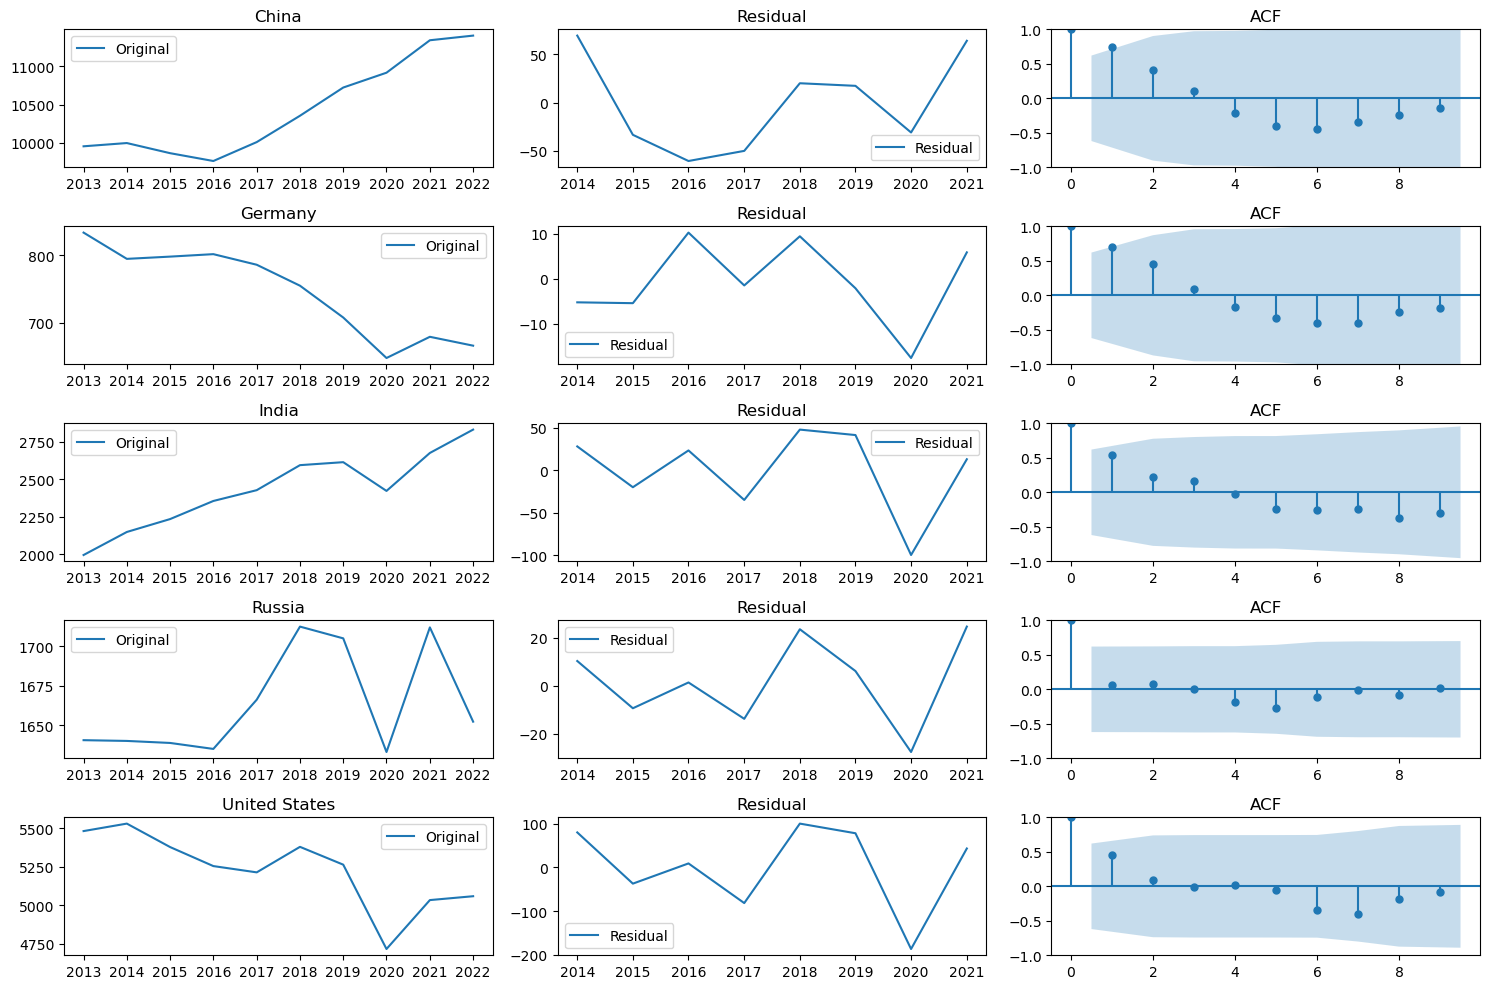

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

data = pd.DataFrame(index=df_test.index.unique(), columns=countries)
for country in countries:
    data[country] = df_test[df_test['country']==country].co2
# Seasonal Decomposition and Autocorrelation for each country
plotnumber = 3
plt.figure(figsize=(plotnumber*5, 10))
for i, country in enumerate(countries, start=1):
    plt.subplot(len(countries), plotnumber, i*plotnumber-(plotnumber-1))
    plt.plot(data[country], label='Original')
    plt.title(country)
    plt.legend(loc='best')
    
    decomposition = seasonal_decompose(data[country], model='additive', period=2)  # Change period based on your data's seasonality
    plt.subplot(len(countries), plotnumber, i*plotnumber-(plotnumber-2))
    plt.plot(decomposition.resid, label='Residual')
    plt.title('Residual')
    plt.legend(loc='best')

    plt.subplot(len(countries), plotnumber, i*plotnumber)
    plot_acf(data[country], lags=9, ax=plt.gca())
    plt.title('ACF')
    
plt.tight_layout()
plt.show()

## Box Plots or Violin Plots
Visualize the distribution of the data across different years using box plots or violin plots to identify any outliers or variability in the data.

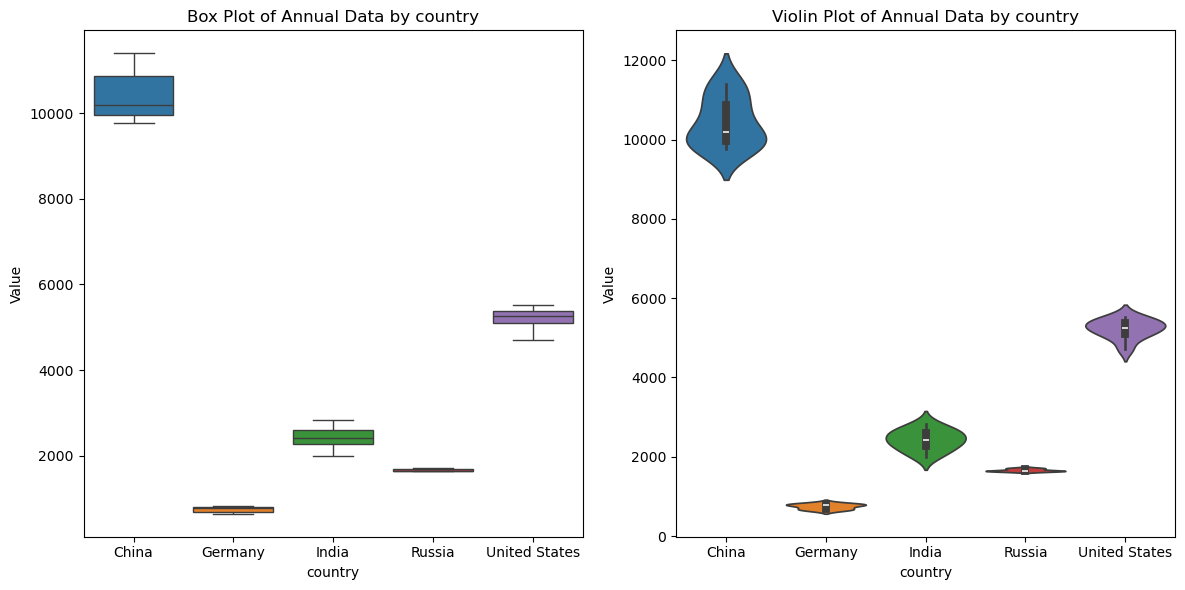

In [14]:
# Create box plots for each country
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(data=data)
plt.title('Box Plot of Annual Data by country')
plt.xlabel('country')
plt.ylabel('Value')

# Create violin plots for each country
plt.subplot(1, 2, 2)
sns.violinplot(data=data)
plt.title('Violin Plot of Annual Data by country')
plt.xlabel('country')
plt.ylabel('Value')

plt.tight_layout()
plt.show()

## Periodogram Analysis
- Compute the periodogram of the data using Fourier analysis or other spectral analysis techniques to identify dominant frequencies corresponding to seasonal cycles. Periodogram analysis can help detect periodic patterns in the data, including seasonal patterns.
- Peaks in the periodograms indicate dominant frequencies or periodic patterns in each country's data, allowing you to compare the seasonal patterns across countries. Adjustments to the code may be needed based on the characteristics of your data and the specific requirements of your analysis.

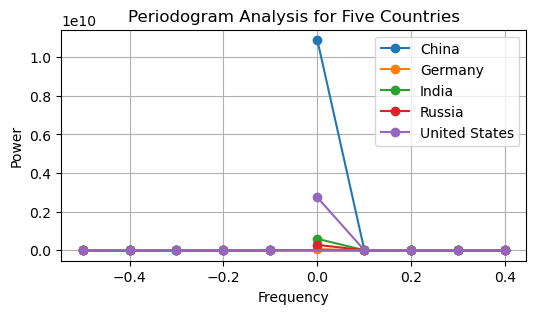

In [15]:
# Calculate the periodogram for each country using FFT (Fast Fourier Transform)
plt.figure(figsize=(6, 3))
for country in countries:
    country_data = data[country]
    periodogram = np.abs(np.fft.fft(country_data))**2
    frequencies = np.fft.fftfreq(len(periodogram))
    plt.plot(frequencies, periodogram, marker='o', linestyle='-', label=country)

plt.title('Periodogram Analysis for Five Countries')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.legend()
plt.grid(True)
plt.show()

# Feature Analysis

## PCA 
identify the most important features in a dataset by transforming the original features into a new set of orthogonal components.

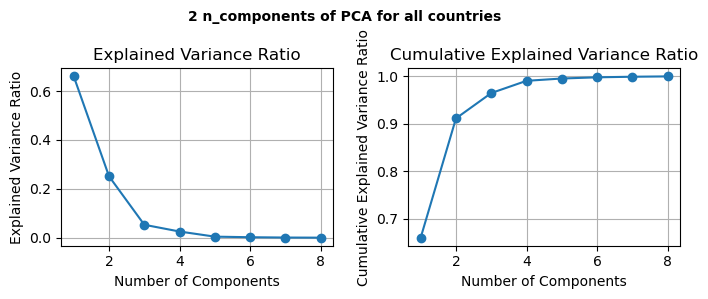

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def find_n_PCA(feature_data, subtitle):
    # Standardize the features (mean=0 and variance=1)
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(feature_data)
    # Fit PCA
    pca = PCA(n_components=len(feature_data.columns))
    pca.fit(df_scaled)
    # find the best components
    pca_gaps = [abs(pca.explained_variance_ratio_[i+1] - pca.explained_variance_ratio_[i]) for i in range(len(pca.explained_variance_ratio_)-1)]
    best_component = pca_gaps.index(max(pca_gaps))+2
    # Plot explained variance ratio and cumulative explained variance ratio
    plt.figure(figsize=(7, 3))
    # Plot explained variance ratio
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o', linestyle='-')
    plt.xlabel('Number of Components')
    plt.ylabel('Explained Variance Ratio')
    plt.title('Explained Variance Ratio')
    plt.grid(True)
    # Plot cumulative explained variance ratio
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='-')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.title('Cumulative Explained Variance Ratio')
    plt.grid(True)
    # Set a single title for both subplots
    plt.suptitle(f'{best_component} n_components of PCA for {subtitle}', fontsize=10, fontweight='bold')
    plt.tight_layout()
    plt.show()
    return best_component, df_scaled

pca_components, df_scaled = find_n_PCA(df_test[features], 'all countries')

# country_n_components = {}
# for country in ['all countries']+ countries:
#     country_n_components[country] = find_n_PCA(df_test[features], country)

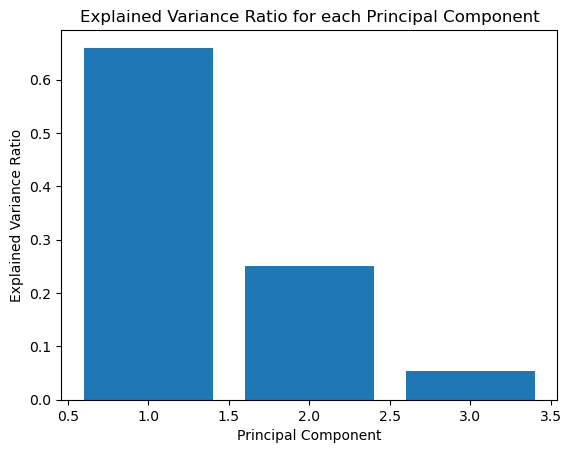

In [17]:
pca_components = 3
# Assuming df_scaled is already defined and contains standardized data
pca = PCA(n_components=(pca_components)) 
pca.fit(df_scaled)

# Transform the data into principal components
df_pca = pca.transform(df_scaled)
pca_columns = ['PC'+str(i) for i in range(1,pca_components+1)]

# Create a DataFrame to store the principal components
df_pca = pd.DataFrame(df_pca, columns=pca_columns)

# Concatenate the original DataFrame with the principal components DataFrame
df_with_pca = pd.concat([df[features].reset_index(drop=True), df_pca], axis=1)

# Plot explained variance ratio
plt.bar(range(1, pca_components+1), pca.explained_variance_ratio_)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio for each Principal Component')
plt.show()

# # Show transformed data with PCA
# print("Transformed data with PCA:")
# print(df_with_pca)

### Loading Scores
- Understanding Feature Importance: By examining the loading scores of the original features on each principal component, you can identify which features contribute most significantly to each PC. This helps in understanding the underlying structure and relationships in the data.
- The loading scores indicate the correlation between each original feature and each principal component. Positive or negative values denote the direction and strength of the relationship. Higher absolute values suggest stronger influence.

                                 PC1       PC2       PC3
population                  0.293429 -0.441221  0.432762
gdp                         0.407861  0.075450 -0.409980
coal_co2                    0.344415 -0.390857 -0.076885
flaring_co2                 0.208143  0.581613  0.431506
gas_co2                     0.318502  0.475123  0.017225
methane                     0.397796 -0.124313  0.526921
oil_co2                     0.400694  0.197218 -0.277006
electricity_generation_twh  0.406649 -0.168812 -0.312808


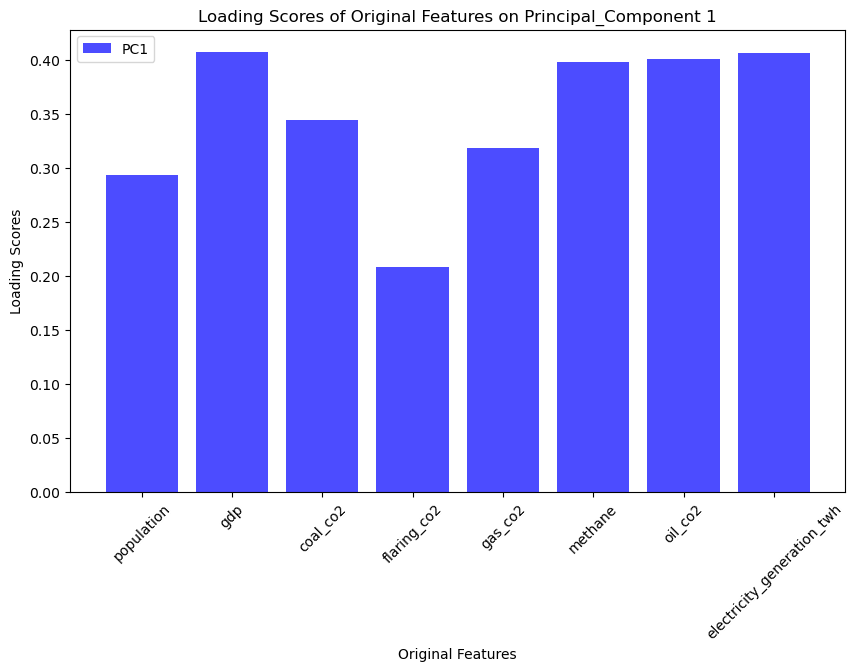

In [18]:
# Get loading scores
loading_scores = pd.DataFrame(pca.components_.T, columns=pca_columns, index=df_test[features].columns)
print(loading_scores)
# Plot loading scores
plt.figure(figsize=(10, 6))
plt.bar(range(len(loading_scores)), loading_scores['PC1'], color='blue', alpha=0.7, label='PC1')

plt.xlabel('Original Features')
plt.ylabel('Loading Scores')
plt.title('Loading Scores of Original Features on Principal_Component 1')
plt.xticks(range(len(loading_scores)), loading_scores.index, rotation=45)
plt.legend()
plt.show()


## Feature Importance

### after PCA

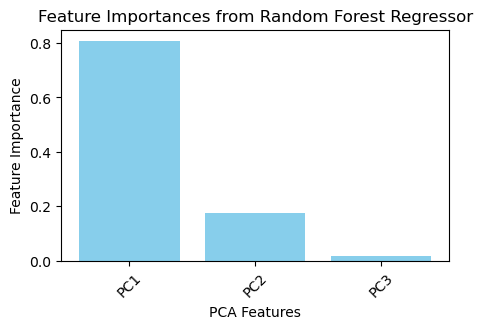

In [19]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

def feature_importance_pca(pca_data, target_data, pca_feature_names):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(pca_data, target_data, test_size=0.2, random_state=42)
    # Train a random forest regressor
    rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_regressor.fit(X_train, y_train)
    # Get feature importances
    feature_importances = rf_regressor.feature_importances_
    
    # Map feature importances to original feature names
    feature_importance_map = dict(zip(pca_feature_names, feature_importances))
    # Sort feature importances
    sorted_feature_importances = sorted(feature_importance_map.items(), key=lambda x: x[1], reverse=True)
    # # Print feature importances
    # print("Feature Importance:")
    # for feature, importance in sorted_feature_importances:
    #     print(f"{feature}: {importance}")
    # Plot feature importances
    plt.figure(figsize=(5, 3))
    plt.bar(range(len(feature_importances)), feature_importances, color='skyblue')
    plt.xlabel('PCA Features')
    plt.ylabel('Feature Importance')
    plt.title('Feature Importances from Random Forest Regressor')
    plt.xticks(range(len(feature_importances)), pca_feature_names, rotation=45)
    plt.show()

feature_importance_pca(df_pca, df_test[target], pca_columns)


### original features

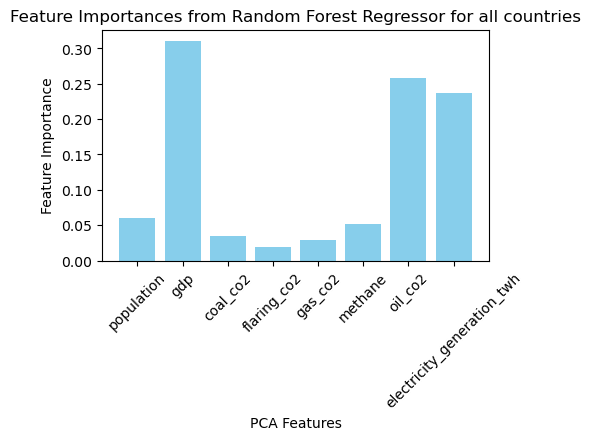

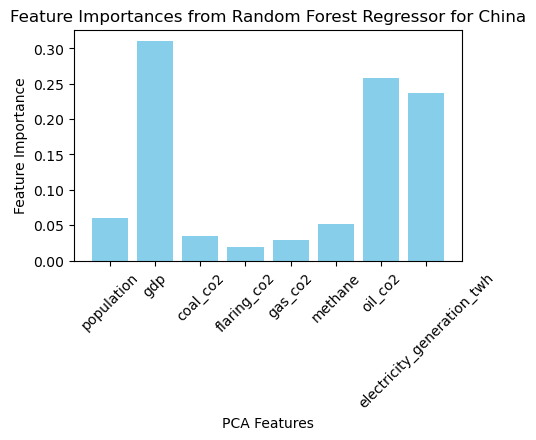

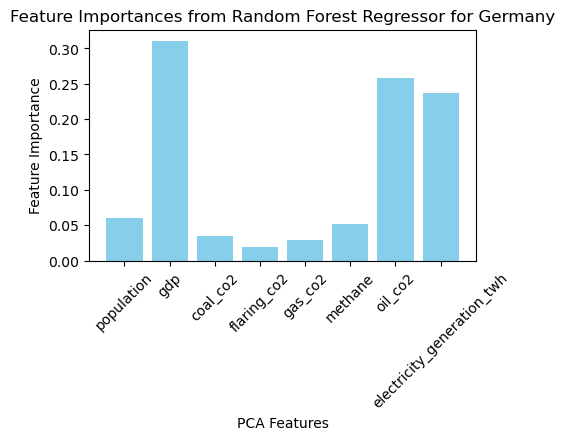

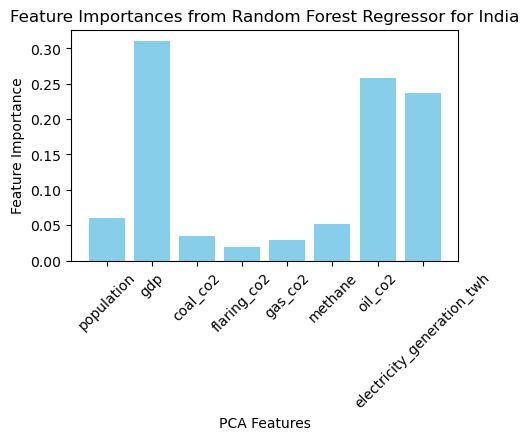

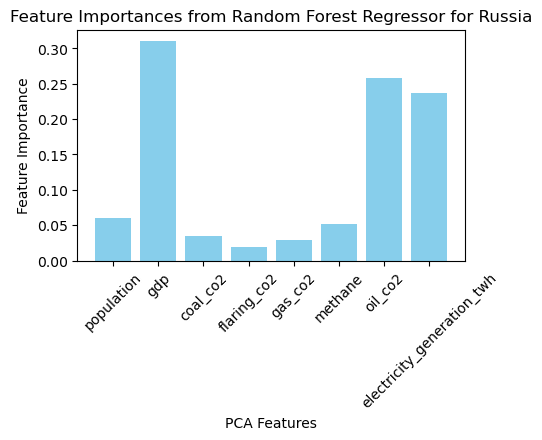

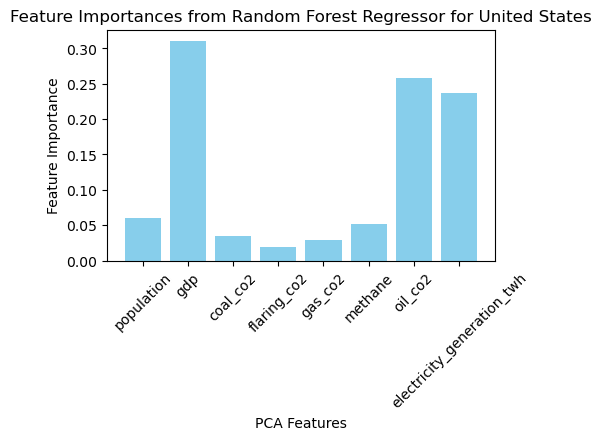

In [20]:
def feature_importance_rf_country(X,y,country):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(df_test[features], df_test[target], test_size=0.2, random_state=42)
    # Train a random forest regressor
    rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_regressor.fit(X_train, y_train)
    # Get feature importances
    feature_importances = rf_regressor.feature_importances_
    # Get oringinal feature names
    original_feature_names = X.columns
    # Map feature importances to original feature names
    feature_importance_map = dict(zip(original_feature_names, feature_importances))
    # Sort feature importances
    sorted_feature_importances = sorted(feature_importance_map.items(), key=lambda x: x[1], reverse=True)
    # # Print feature importances
    # print("Feature Importance:")
    # for feature, importance in sorted_feature_importances:
    #     print(f"{feature}: {importance}")
    # Plot feature importances
    plt.figure(figsize=(5, 3))
    plt.bar(range(len(feature_importances)), feature_importances, color='skyblue')
    plt.xlabel('PCA Features')
    plt.ylabel('Feature Importance')
    plt.title(f'Feature Importances from Random Forest Regressor for {country}')
    plt.xticks(range(len(feature_importances)), original_feature_names, rotation=45)
    plt.show()

# feature_importance_rf_country(df_test[features], df_test[target], 'all countries')
for country in ['all countries']+countries:
    if country == 'all countires': country_data = df_test
    else: country_data = df_test[df_test['country']==country]
    feature_importance_rf_country(country_data[features],country_data[target],country)

## mutual_info_regression

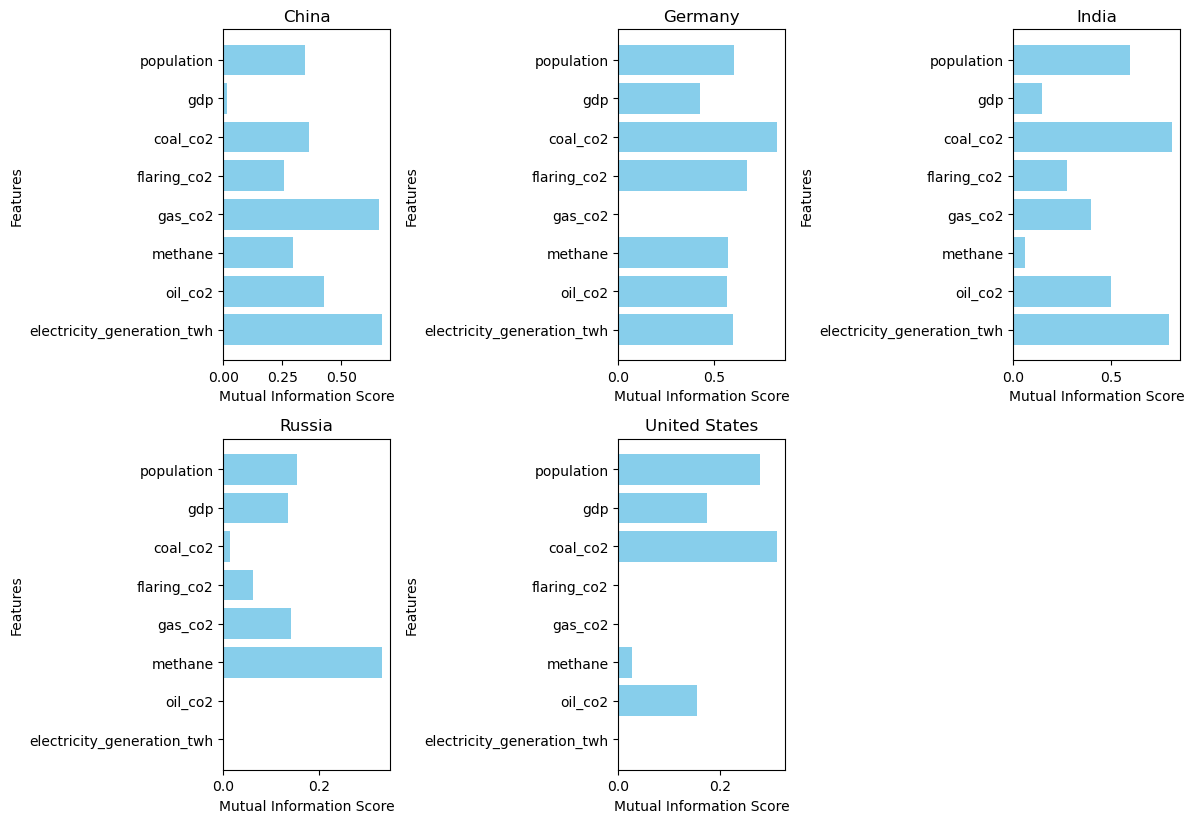

In [21]:
from sklearn.feature_selection import mutual_info_regression

n_countries = len(countries)


# Plot mutual information scores for all countries together
plt.figure(figsize=(12, 12))

# Collect mutual information scores for all countries
all_mutual_info_scores = []
for country in countries:
    features_country = df_test[df_test['country'] == country].drop(columns=['country',target])
    target_country = df_test[df_test['country'] == country].co2
    mutual_info_scores = mutual_info_regression(features_country, target_country)
    all_mutual_info_scores.append(mutual_info_scores)

# # Calculate mean mutual information scores across all countries
# mean_mutual_info_scores = np.mean(all_mutual_info_scores, axis=0)

# # Plot mutual information scores for all countries together
# plt.subplot(3, 3, 1)
# plt.barh(features, mean_mutual_info_scores, color='skyblue')
# plt.xlabel('Mean Mutual Information Score')
# plt.ylabel('Features')
# plt.title('All Countries')
# plt.gca().invert_yaxis()  # Invert y-axis to show features at the top
# plt.tight_layout()

# Plot mutual information scores for each country individually
for i, (country, mutual_info_scores) in enumerate(zip(countries, all_mutual_info_scores), 1):
    plt.subplot(3, 3, i )
    plt.barh(features, mutual_info_scores, color='skyblue')
    plt.xlabel('Mutual Information Score')
    plt.ylabel('Features')
    plt.title(f'{country}')
    plt.gca().invert_yaxis()  # Invert y-axis to show features at the top
    plt.tight_layout()

plt.show()